In [1]:
import seaborn as sns
import autograd.numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
# package which differentiates standard Python and Numpy code
from autograd import grad
# to get progress bars
from tqdm import tqdm
import scipy.io as sio
import random
from scipy.sparse import coo_matrix
import time
sns.set_style("whitegrid")

## Langevin MCMC
With differentiable target densities

### Unadjusted Langevin Algorithm

In [2]:
def ULA(n_samples, initial_state, log_p, step_size):

    d = len(initial_state)
    samples = np.zeros((n_samples,d))
    x = initial_state
    grad_log_p = grad(log_p)

    for i in range(n_samples):
        x += step_size / 2 * grad_log_p(x) + np.sqrt(step_size) * scs.multivariate_normal.rvs(size=d)
        samples[i,:] = x
        
    return samples

### Metropolis Adjusted Langevin Algorithm



In [3]:
def MALA(n_samples, initial_state, log_p, step_size):

    d = len(initial_state)
    samples = np.zeros((n_samples,d))
    accepted = np.zeros(n_samples)
    x = initial_state
    grad_log_p = grad(log_p)

    for i in range(n_samples):
        y = x + step_size / 2 * grad_log_p(x) + np.sqrt(step_size) * scs.norm.rvs(size=d)
        samples[i] = y
        log_q = lambda x, y : scs.norm.logpdf(y, x + step_size / 2 * grad_log_p(x), step_size * np.eye(d))
        
        if log_p(y) + log_q(y,x) - log_p(x) - log_q(x,y) < 0:
            y = x
            accepted[i] = 1
        else:
            accepted[i] = 0
            
    return samples, accepted

### Illustration (In 1D)

In [4]:
def log_gauss(mu, sigma):
    return lambda x : - ((x - mu) / sigma)**2 / 2 - np.log(sigma * np.sqrt(2 * np.pi))

log_quartic_dist = lambda x : - x**4

In [134]:
def hist_and_true_dens(samples, log_density, figname):
    x = np.linspace(min(samples), max(samples), len(samples))
    sns.histplot(samples, stat='density', legend=False)
    plt.plot(x, np.exp(log_density(x)), color='darkblue', label='Target density')
    plt.title(figname, fontsize=14)
    plt.legend()


def test_convergence_mean(samples_list, param_name, params, target_mean, ylim=[]):
    plt.figure(figsize=(8.0,5.0))
    if len(ylim) != 0:
        plt.ylim((ylim[0], ylim[1]))
    plt.axhline(target_mean, color="black", lw=2, label='Target mean')

    for k in range(len(params)):
        samples = samples_list[k]
        t = np.arange(1, len(samples) + 1)
        samples_sum = np.cumsum(samples) / t
        plt.plot(t, samples_sum,  lw=1.2, label=param_name+'='+str(params[k]))

    plt.legend()


def plot_accept_prob(accept_list, param_name, params):
    y = np.empty_like(params)
  
    for k in range(len(params)):
        accept = accept_list[k]
        y[k] = len(accept[accept == 1]) / len(accept)
  
    plt.figure(figsize=(7.2,4.5))
    plt.semilogy(params, y)
    plt.xlabel(param_name)
    plt.ylabel('Acceptance probability')

In [138]:
log_p = log_gauss(mu=2,sigma=5)
n_samples = 3000
x0 = np.array([2])
step_size = 30
MALA_samples, accepted = MALA(n_samples, x0, log_p, step_size)
MALA_samples_accepted = MALA_samples[accepted == 1]

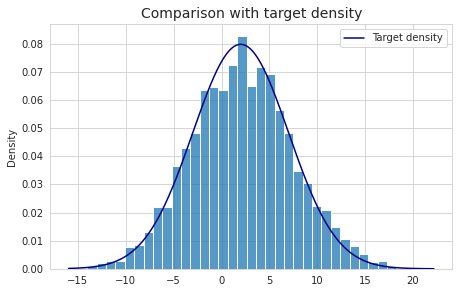

In [139]:
plt.figure(figsize=(7.2,4.5))
hist_and_true_dens(MALA_samples_accepted, log_p, "Comparison with target density")

In [159]:
log_p = log_gauss(mu=2,sigma=5)
n_samples = 300
x0 = np.array([5])
step_sizes = np.array([2, 10, 22, 35, 80])
MALA_samples_list = []

for step_size in step_sizes:
    MALA_samples, accepted = MALA(n_samples, x0, log_p, step_size)
    MALA_samples_list.append(MALA_samples[accepted == 1])


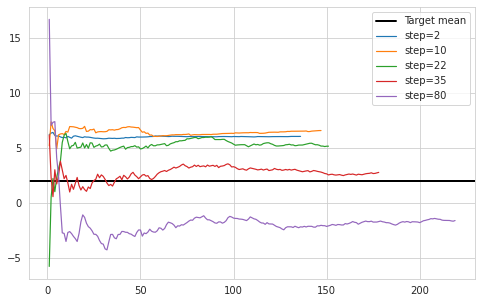

In [160]:
test_convergence_mean(MALA_samples_list,'step' ,step_sizes, 2, ylim=[])

In [161]:
log_p = log_gauss(mu=2,sigma=5)
n_samples = 3000
x0 = np.array([5])
step_sizes = np.linspace(1,100,10)
MALA_accept_list = []

for step_size in step_sizes:
    _, accepted = MALA(n_samples, x0, log_p, step_size)
    MALA_accept_list.append(accepted)

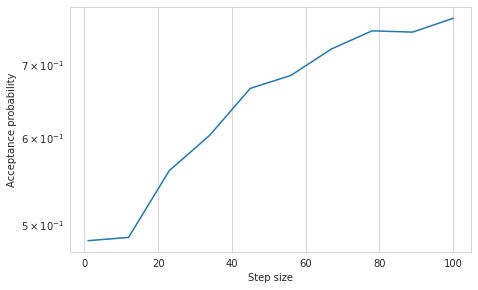

In [162]:
plot_accept_prob(MALA_accept_list, 'Step size', step_sizes)

#### MALA Adversarial example

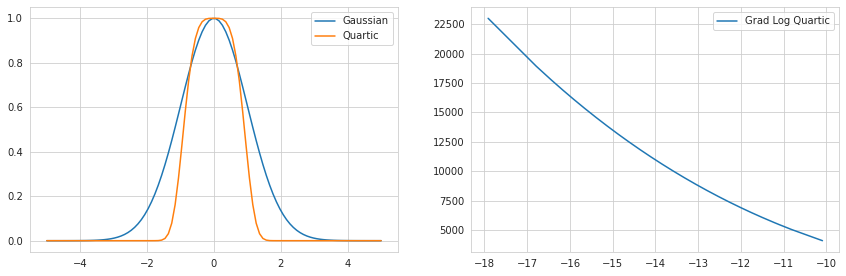

In [26]:
x = np.linspace(-5,5,100)
plt.figure(figsize=(14.5,4.5))

plt.subplot(1,2,1)
plt.plot(x, np.exp(log_gauss(0,1)(x)) * np.sqrt(2 * np.pi), label='Gaussian')
plt.plot(x, np.exp(log_quartic_dist(x)), label='Quartic')
plt.legend()

log_p = log_quartic_dist
n_samples = 3000
x0 = np.array([2])
step_size = 1
MALA_samples, accepted = MALA(n_samples, x0, log_p, step_size)
MALA_samples = MALA_samples[accepted == 1]

plt.subplot(1,2,2)
#plt.ylim((-10,10))
grad_q = grad(log_quartic_dist)
x = sorted(MALA_samples)
y = np.array([grad_q(x_j) for x_j in x])
plt.plot(x, y, label='Grad Log Quartic')
plt.xlabel('samples')
plt.legend()

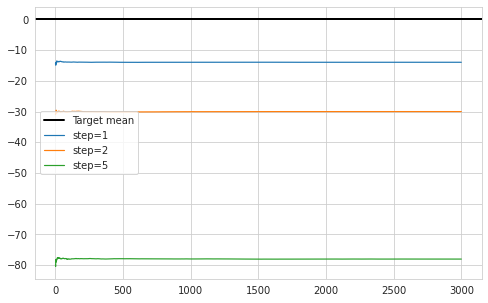

In [ ]:
log_p = log_quartic_dist
n_samples = 3000
x0 = np.array([2])
step_sizes = np.array([1, 2, 5])
MALA_samples_list = []

for step_size in step_sizes:
    MALA_samples, accepted = MALA(n_samples, x0, log_p, step_size)
    MALA_samples_list.append(MALA_samples[accepted == 1])

test_convergence_mean(MALA_samples_list,'step' ,step_sizes, 0, ylim=False)

## Proximal Langevin 
Using proximal mappins for non differentiable and log-concave target densities


####P-MALA

In [1]:
def pmala(X0=None,g=None,proxg=None,options=None):
    
# Check for required inputs
# Check for optional inputs
# ----------------------------------------------------------- Simulation setup -----------------------------------------------
  # Allocate chains
    n = X0.shape # gives num of rows and cols of X0
    Xchain = np.zeros((int(options['samples']),)+n) # dimension 3 
  #print(Xchain.shape)
    gTrace = np.zeros(int(options['samples'] * options['thinning']))  
    acceptTrace = np.zeros(int(options['samples'] * options['thinning'])) 

  # Initialize variables
    delta = options['delta']       # delta controls the proposal variance, the discrete-time step length and the Moreau approximation
    lamda = options['lambda']
    Xcur = X0               # set initial state as current state
    proxgXcur = proxg(Xcur,lamda)    # pre-compute proxg(Xcur)
    gXcur=g(Xcur)              # pre-compute g(Xcur)
    gTrace[0]=gXcur             # record value g(Xcur) as a scalar summary
    if n[1]==1:
        Xchain[0,:] = Xcur;             # record initial sample (X is in vector form)
    else:
        Xchain[0,:,:] = Xcur;           # record initial sample (X is in matrix form)
    
  # Set the appropriate norm for 'X'
    if n[1]==1:
        p = 2      # L2 norm (X is in vector form)
    else:
        p = 'fro'  # Frobenius (X is in matrix form)
  # --------------------------------------------------------- Run simulation -----------------------------------------------
  # activate "progress bar" if options['display'] = 1
  # if options['display']:
  #   progressbar

    time_start=time.time()
  #for ii in tqdm(range(1, int(options['samples'] * options['thinning']))): # with progress bar
    for ii in range(1, int(options['samples'] * options['thinning'])):
        # Generate candidate using P-ULA proposal
        if lamda == delta / 2:
            Xnew = proxgXcur + np.sqrt(delta)*np.random.randn(n[0],n[1])
        else:
            Xnew = (1 - delta / (2*lamda)) * Xcur + (delta / (2*lamda)) * proxgXcur + np.sqrt(delta)*np.random.randn(n[0],n[1])
    
    # Compute Metropolis-Hastings ratio: target ratio
        gXnew = g(Xnew)
        logPiRatio = gXnew - gXcur
    # Compute Metropolis-Hastings ratio: proposal ratio
        proxgXnex = proxg(Xnew,delta/2)
        logPropRatio = (np.linalg.norm(Xnew - proxgXcur,p)**2 - np.linalg.norm(Xcur - proxgXnex,p)**2)/(2*delta);
    
    # Accept-Reject candidate
        if np.log(np.random.rand(1)) < (logPiRatio + logPropRatio):
            Xcur = Xnew;                # set candidate as new current
            acceptTrace[ii]=1               # record that the candidate was accepted
            proxgXcur = proxgXnex           # record proxg(Xnew) for next iteration
            gXcur = gXnew              # record g(Xnew) for next iteration
    # Record value g(Xcur) as a scalar summary
        gTrace[ii] = gXcur
    
    # Record sample (with thinning)
        if not np.mod(ii,options['thinning']):
            if n[1]==1:
                Xchain[round(ii/options['thinning']) ,:] = Xcur;    # X is vector
            else:
                Xchain[round(ii/options['thinning']),:,:] = Xcur;  # X is matrix

    # Adapt the value of delta to achieve an appropriate acceptance rate (only during burn-in period)
        if options['updateDelta']:
            if ii < options['burnIn']*options['thinning']:
                if not np.mod(ii,options['updateDelta']):
          # Estimate acceptance probability over the last
          # 'options.updateDelta' iterations
                    accRate = np.mean(acceptTrace[int(ii-options['updateDelta']): int(ii)])
                
          # If accRate is 1% higher than targetRate increase delta
          # by 25%, otherwise if 1% lower decrease by 20%.
                    if accRate>options['targetRate']*1.01:
                        delta = delta*1.25
                        lamda = delta / 2
                    elif accRate<options['targetRate']/1.01:
                        delta = delta*0.8
                        lamda = delta / 2

    
    time_s = time.time()-time_start
    return Xchain,gTrace,acceptTrace,time_s,delta

#### Illustration

##### Simulate from univariate Laplace distribution

In [7]:
# Define g = \log\pi(x)
def g1(X):
    return -np.abs(X)
# Define proximity mapping of g(x) = log\pi(x)
def proxg1(X, lamda):
    return np.dot(np.sign(X),(np.max((np.abs(X),lamda))-lamda))

In [67]:
# Sampler setup
def def_options(samples, thinning, delta, lamda, display, targetRate, updateDelta, burnIn):
  options = {}
  options['samples'] = samples # total number of samples
  options['thinning'] = thinning # thinning factor (i.e., iterations per sample)
  options['delta'] = delta # value of time-discretisation step "delta"
  options['lambda'] = lamda
  options['display'] = display # do not display progressbar
  options['targetRate'] = targetRate # target an acceptance probability of around 60%
  options['updateDelta'] = updateDelta # adjust the value of delta every ... iterations
  options['burnIn'] = burnIn # adjust the value of delta only during the first ... iterations
  
  return options

In [81]:
options = def_options(samples=5e3, thinning=1, delta=5, lamda=3, display=0, targetRate=0.6, 
                      updateDelta=0, burnIn=0)

X0 = np.random.rand(1, 1)
lamdas = [0.5, 3, 10, 50]
PMALA_samples_list = []

for lamda in lamdas:
  options['lambda'] = lamda
  PMALA_samples, _, _, _, delta = pmala(X0,g1,proxg1,options)
  PMALA_samples = PMALA_samples.reshape(PMALA_samples.shape[0],PMALA_samples.shape[1])
  PMALA_samples_list.append(PMALA_samples[accepted == 1])

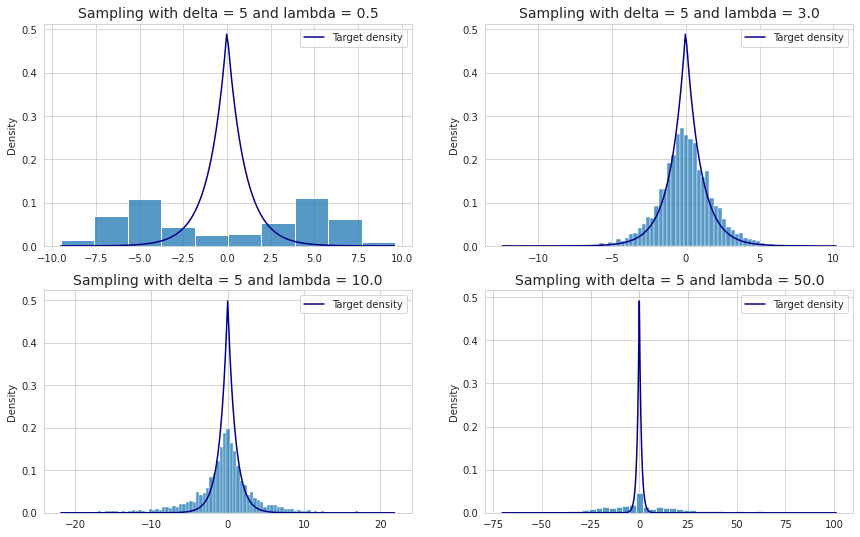

In [82]:
log_p = lambda x : g1(x) - np.log(2)

plt.figure(figsize=(14.5,9))

for i in range(1,len(PMALA_samples_list)+1):
  plt.subplot(2,2,i)
  hist_and_true_dens(PMALA_samples_list[i-1], log_p, "Sampling with delta = {0} and lambda = {1}".format(delta,lamdas[i-1]))

In [88]:
options = def_options(samples=1e4, thinning=1, delta=5, lamda=3, display=0, targetRate=0.6, 
                      updateDelta=20, burnIn=1e4)

X0 = np.random.rand(1, 1)
target_rates = [0.3, 0.45, 0.55, 0.65, 0.85]
PMALA_samples_list = []

for rate in target_rates:
  options['targetRate'] = rate
  PMALA_samples, _, accepted, _, _ = pmala(X0,g1,proxg1,options)
  PMALA_samples = PMALA_samples.reshape(PMALA_samples.shape[0],PMALA_samples.shape[1])
  PMALA_samples_list.append(PMALA_samples[accepted == 1])

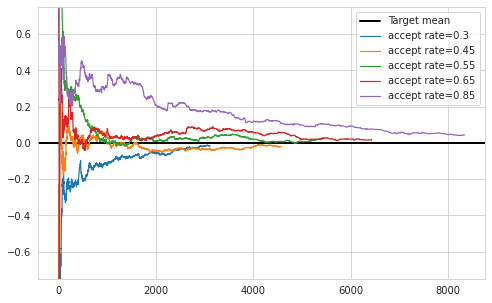

In [92]:
test_convergence_mean(PMALA_samples_list,'accept rate' ,target_rates, 0, ylim=[-0.75,0.75])

#####Simulate from univariate Quartic distribution

In [93]:
# Define g = \log\pi(x)
def g3(X):
    return -pow(X,4)
# Define proximity mapping of g(x) = log\pi(x)
# Compute prox of pi(x) \ propto exp(-gamma*x^4)
def proxg3(X, lamda):
    p = 1.0/(4.*lamda)
    q = 1.0*X/(4.*lamda)
    w3 = (np.sqrt(q**2+(4./27)*p**3)-q)/2.
    w = w3 ** (1/3)
    u = p/(3.*w) - w
    return u

In [94]:
from scipy.integrate import quad

quartic_p = lambda x : np.exp(- x**4)
const = quad(quartic_p, -np.inf, np.inf)[0] # compute normalisation constant

In [117]:
options = def_options(samples=1e4, thinning=1, delta=1, lamda=0.75, display=0, targetRate=0.6, 
                      updateDelta=0, burnIn=1e4)
X0 = np.random.rand(1, 1) # set initial state
# Run P-MALA
PMALA_samples, _, accepted, _, delta = pmala(X0,g3,proxg3,options)
PMALA_samples = PMALA_samples.reshape(PMALA_samples.shape[0],PMALA_samples.shape[1])

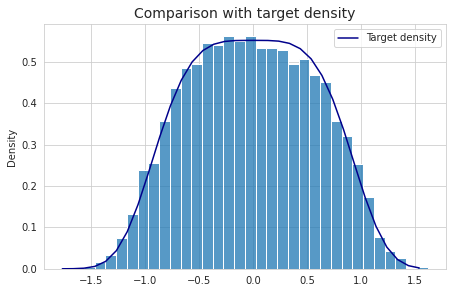

In [118]:
PMALA_samples_accepted = PMALA_samples[accepted == 1]
log_p = lambda x : g3(x) - np.log(const)
plt.figure(figsize=(7.2,4.5))
hist_and_true_dens(PMALA_samples_accepted, log_p, "Comparison with target density")

Text(0.5, 1.0, 'Proximity mappings')

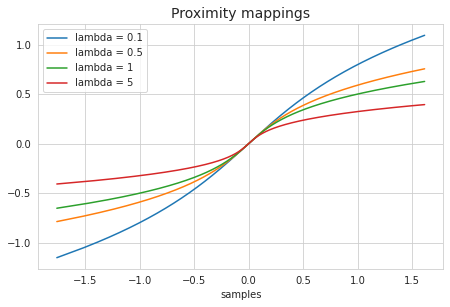

In [124]:
plt.figure(figsize=(7.25,4.5))

lamdas = [0.1, 0.5, 1, 5]
x = sorted(PMALA_samples_accepted)

for i in range(1,len(lamdas)+1):
  y = np.array([proxg3(x_j, lamdas[i-1]) for x_j in x])
  plt.plot(x, y, label="lambda = {0}".format(lamdas[i-1]))

plt.xlabel('samples')
plt.legend()
plt.title("Proximity mappings",fontsize=14)
